# <center> Project - Data Wrangling & Analyzing</center>
## <center>Udacity Data Analyst Nanodegree</center>

## Table of Contents
- **[Project Introduction](#intro)**
- **[Gather Data](#gather)**
    - [Twitter_Archive](#g1)
    - [Image_Predictions](#g2)
    - [Tweet_data](#g3)
- **[Assess Data](#assess)**
    - [Twitter_Archive](#a1)
    - [Image_Predictions](#a2)
    - [Tweet_data](#a3)
    - [assessment summary](#asum)
- **[Clean Data](#clean)**
    - Q1 - [Remove entries with retweets](#q1)
    - Q2 - [Remove entries without pictures](#q2)
    - Q3 - [Drop unnecessary columns (in_reply_to_status_id, in_reply_to_user_id, user_favourites)](#q3)
    - T1 - [Melt image prediction columns](#t1)
    - Q4 - [Fix rating numerator & denominator columns (multiple ratings)](#q4)
    - Q5 - [Fix rating numerator & denominator columns (incorrect ratings)](#q5)
    - Q6 - [Fix rating numerator & denominator columns (remove decimals)](#q6)
    - T2 - [Melt doggo, floofer, pupper, puppo columns](#t2)
    - Q7 - [Fix dog prediction values (NULL to None)](#q7)
    - Q8 - [Fix datatypes (multiple issues)](#q8)
- **[Analysis & Visualization](#av)**
    - Question 1: [What is the most common dog type?](#quest1)
    - Question 2: [Is there a correlation between retweets & likes?](#quest2)
    - Question 3: [What did the rating distributions look like?](#quest3)

<a id='intro'></a>
## Project Introduction

This project will focus on wrangling data along with some light analyzing and visualization.  The datasets will include the tweet archive of Twitter user @dog_rates, also known as WeRateDogs, a compilation of ratings and comment about various dogs. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.  I will look to combine this dataset with a few others utilizting the following libraries
- pandas
- NumPy
- requests
- tweepy
- json


<a id='gather'></a>
## Gather Data

In [1]:
#import libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import requests
import seaborn as sns
import time
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
import warnings

### Files to import
1. **twitter_archive**: import a csv filed form the the WeRateDogs twitter archive
2. **image_predictions**: download programmatically from web as a tsv file
3. **tweet_data**: query Twitter API for JSON data via tweepy

<a id='g1'></a>
### File#1 - WeRateDogs

In [2]:
#import csv file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#check dataframe size
print("this dataset has", twitter_archive.shape[0], "columns, and", twitter_archive.shape[1], "rows")

this dataset has 2356 columns, and 17 rows


In [4]:
#test import
twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


<a id='g2'></a>
### File#2 - Image Predictions

In [5]:
# Make directory if it doesn't already exist
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [6]:
#import tsv file from web
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [7]:
#check dataframe size
print("this dataset has", image_predictions.shape[0], "columns, and", image_predictions.shape[1], "rows")

this dataset has 2075 columns, and 12 rows


In [8]:
#test import
image_predictions.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='g3'></a>
### File#3 - Retweet & Like Counts

In [9]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
API_KEY = "LbV39S9pi1fkfzlTlD8HAtKnJ"
API_SECRET_KEY = "Utwfqm36MvA2wqsdDNOgEkdI5TZPkEYYTg09TrPDzaMeJqonC9"
ACCESS_TOKEN = "175566825-dVnjPHbydqu6HYMHXYzZE8IfQCcH93UBG48xr20u"
ACCESS_TOKEN_SECRET = "kCSAaTbAhX2aGZ5pvnTqkUZ2c9U35QRW2jqoPKEEBgZTk"

auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth)

In [10]:
df_list = []
error_list = []

start = time.time()

# Will add each available tweet json to df_list
for tweet_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit = True,
                               wait_on_rate_limit_notify = True)._json 
        favorites = tweet['favorite_count'] # tweet's favorites
        retweets = tweet['retweet_count'] 
        user_followers = tweet['user']['followers_count'] 
        user_favourites = tweet['user']['favourites_count'] # user's favorites
        date_time = tweet['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id), 'favorites': int(favorites), 'retweets': int(retweets),
                        'user_followers': int(user_followers), 'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
        
    except Exception as e:
        print(str(tweet_id)+ " __ " + str(e))
        error_list.append(tweet_id)
        

end = time.time()
print(end - start)

888202515573088257 __ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 __ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 __ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 __ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 __ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 __ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 __ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 __ [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 __ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 __ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 __ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 __ [{'code': 144, 'message': 'No status found with that ID.'}]
8373662848745717

Rate limit reached. Sleeping for: 734


754011816964026368 __ [{'code': 144, 'message': 'No status found with that ID.'}]
680055455951884288 __ [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 726


1920.6507518291473


In [13]:
print("this returned", len(df_list), "results, and", len(error_list), "errors")

this returned 2331 results, and 25 errors


**we reached the rate limit twice for a total time of 23 minutes**

In [14]:
# Create DataFrames 'json' and save it in a file
json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets', 'user_followers',
                                               'user_favourites', 'date_time'])
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [15]:
tweet_data = pd.read_csv('tweet_json.txt', encoding = 'utf-8')

In [16]:
#check dataframe size
print("this dataset has", tweet_data.shape[0], "columns, and", tweet_data.shape[1], "rows")

this dataset has 2331 columns, and 6 rows


In [17]:
#test import
tweet_data.head(1)

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,35452,7485,8880079,145875,2017-08-01 16:23:56+00:00


<a id='assess'></a>
## Assess Data

<a id='a1'></a>
### Twitter_archive

In [18]:
twitter_archive.timestamp.sort_values()

2355    2015-11-15 22:32:08 +0000
2354    2015-11-15 23:05:30 +0000
2353    2015-11-15 23:21:54 +0000
2352    2015-11-16 00:04:52 +0000
2351    2015-11-16 00:24:50 +0000
                  ...            
4       2017-07-29 16:00:24 +0000
3       2017-07-30 15:58:51 +0000
2       2017-07-31 00:18:03 +0000
1       2017-08-01 00:17:27 +0000
0       2017-08-01 16:23:56 +0000
Name: timestamp, Length: 2356, dtype: object

**No dates extend past 8/1/2017**

In [19]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1075,739623569819336705,NaN,NaN,2016-06-06 01:02:55 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here's a doggo that don't need no human. 12/10...,NaN,NaN,NaN,https://vine.co/v/iY9Fr1I31U6,12,10,None,doggo,None,None,None
1147,726935089318363137,NaN,NaN,2016-05-02 00:43:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sprout. He's just precious af. 12/10 I...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/726935089...,12,10,Sprout,None,None,None,None
2192,668932921458302977,NaN,NaN,2015-11-23 23:23:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Herald. He likes to swing. Subtle tong...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668932921...,9,10,Herald,None,None,None,None
1766,678399652199309312,NaN,NaN,2015-12-20 02:20:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This made my day. 12/10 please enjoy https://t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678399652...,12,10,None,None,None,None,None
1341,704847917308362754,NaN,NaN,2016-03-02 01:56:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Yes hi could I get a number 4 with no pickles...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/704847917...,12,10,None,None,None,None,None


<font color = 'red'>**Issues Found**</font>
- *Tidiness*: doggo, floofer, pupper, and puppo columns need to be merged into one (some rows missing designation)
- *Quality*: there are rows with retweets (do not need these)
- *Quality*: since we will remove retweets, the retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp are not needed

In [20]:
len(twitter_archive.tweet_id.duplicated())

2356

Showing 2356 duplicated tweet_ids

In [21]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

<font color = 'red'>**Issues Found**</font>
- *Quality*: timestamp field is an object, should be datetime

In [22]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


<font color = 'red'>**Issues found**</font>
- *Quality*: issues with numerator & denominator values
    - numerator has max value of 1776?
    - denominaor should always be 10, but we show a minimum of 0 and max of 170

In [23]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

<font color = 'red'>there looks to be several values outside what would be considered a normal range, 0-20</font>
- these could be typos or people not understanding the rating system
- will consider anything over 20 as an error

In [24]:
twitter_archive.name.value_counts()

None        745
a            55
Charlie      12
Cooper       11
Oliver       11
           ... 
Mingus        1
Henry         1
Champ         1
Jessifer      1
Yoda          1
Name: name, Length: 957, dtype: int64

<font color = 'red'>**Issues Found**</font>
- *Quality*: there are 745 names showing as "none" and 55 showing as just "a"

<a id='a2'></a>
### Image Predictions

In [25]:
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1812,833124694597443584,https://pbs.twimg.com/media/C4_ad1IUoAEspsk.jpg,3,Cardigan,0.710523,True,kelpie,0.106102,True,shopping_cart,0.055475,False
1815,833826103416520705,https://pbs.twimg.com/media/C5JYaYoVYAAcEQw.jpg,1,Chihuahua,0.438054,True,kelpie,0.149706,True,Pembroke,0.096480,True
1009,709225125749587968,https://pbs.twimg.com/media/Cdese-zWEAArIqE.jpg,1,Labrador_retriever,0.271109,True,Pomeranian,0.150487,True,golden_retriever,0.145578,True
752,688116655151435777,https://pbs.twimg.com/media/CYyucekVAAESj8K.jpg,1,pug,0.973819,True,Chihuahua,0.010891,True,Staffordshire_bullterrier,0.006864,True
1028,710997087345876993,https://pbs.twimg.com/media/Cd34FClUMAAnvGP.jpg,1,malamute,0.281260,True,Eskimo_dog,0.232641,True,Pembroke,0.091602,True


<font color = 'red'>**Issues Found**</font>
- *Tidiness*: p1, p2, p3 columns can be merged
- *Quality*: some dogs have multiple True values for different dog types -see 881, 1693, 1941, 2070 above

In [26]:
len(image_predictions.tweet_id.duplicated())

2075

In [27]:
image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [28]:
image_predictions.img_num.isin([0]).sum()

0

All tweets have images!!

In [29]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


<a id='a3'></a>
### Tweet_data

In [30]:
tweet_data.sample(5)

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
1079,735256018284875776,3242,852,8880089,145875,2016-05-24 23:47:49+00:00
1941,673343217010679808,917,252,8880023,145875,2015-12-06 03:28:27+00:00
1627,683498322573824003,3087,939,8880088,145875,2016-01-03 04:01:13+00:00
1048,739979191639244800,19450,5737,8880089,145875,2016-06-07 00:36:02+00:00
1918,673709992831262724,793,252,8880023,145875,2015-12-07 03:45:53+00:00


<font color = 'red'>**issues Found**</font>
- *Quality*: user_favorites column header spelling

In [31]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2331 non-null   int64 
 1   favorites        2331 non-null   int64 
 2   retweets         2331 non-null   int64 
 3   user_followers   2331 non-null   int64 
 4   user_favourites  2331 non-null   int64 
 5   date_time        2331 non-null   object
dtypes: int64(5), object(1)
memory usage: 109.4+ KB


<font color = 'red'>**Issues Found**</font>
- *Quality*: timestamp field is an object, should be datetime

In [32]:
tweet_data.date_time.sort_values()

2330    2015-11-15 22:32:08+00:00
2329    2015-11-15 23:05:30+00:00
2328    2015-11-15 23:21:54+00:00
2327    2015-11-16 00:04:52+00:00
2326    2015-11-16 00:24:50+00:00
                  ...            
4       2017-07-29 16:00:24+00:00
3       2017-07-30 15:58:51+00:00
2       2017-07-31 00:18:03+00:00
1       2017-08-01 00:17:27+00:00
0       2017-08-01 16:23:56+00:00
Name: date_time, Length: 2331, dtype: object

**No dates extend past 8/1/2017**

<a id='asum'></a>
### <font color = 'red'>Assessment Summary</font>
#### Twitter_Archive
- *Tidiness*: doggo, floofer, pupper, puppo columns need to be merged
- *quality*: rating_denominator should be 10 for all
- *quality*: rating_numerator has several out of range values
- *quality*: timestamp column has wrong datatype
- *quality*: retweets need to be removed
- *quality*: retweet columns can be removed after retweets are removed
- *quality*: several dog names are missing

#### Image_Predictions
- *Tidiness*: p1, p2, p3 columns need to be merged
- *quality*: showing duplicate tweet id's
- *quality*: multiple true values for individual dogs

#### Image_Predictions
- *quality*: user_favorites header is spelled incorrectly
- *quality*: timestamp column has wrong datatype

<a id='clean'></a>
## Clean Data

### Prep dataframes for cleaning

In [33]:
# make clean copies of the dataframesabs
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_data_clean = tweet_data.copy()

In [34]:
#merge all image_predicitons & tweet data dataframes into the twitter_archive dataframe
twitter_archive_clean = pd.merge(left=twitter_archive_clean,
                                 right=tweet_data_clean, left_on='tweet_id', right_on='tweet_id', how='inner')

In [35]:
twitter_archive_clean = twitter_archive_clean.merge(image_predictions_clean, on='tweet_id', how='inner')

In [36]:
#verify merge
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2059 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2059 non-null   object 
 4   source                      2059 non-null   object 
 5   text                        2059 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2059 non-null   object 
 10  rating_numerator            2059 non-null   int64  
 11  rating_denominator          2059 non-null   int64  
 12  name                        2059 non-null   object 
 13  doggo                       2059 

<a id='csum'></a>
### <font color = 'red'>Cleaning Summary</font>

#### List of fixes
1. Q1 - Remove entries with retweets
2. Q2 - Remove entries without pictures
3. Q3 - Drop unnecessary columns (in_reply_to_status_id, in_reply_to_user_id, user_favourites)
4. T1 - Melt image prediction columns
5. Q4 - Fix rating numerator & denominator columns (multiple ratings)
6. Q5 - Fix rating numerator & denominator columns (incorrect ratings)
7. Q6 - Fix rating numerator & denominator columns (remove decimals)
8. T2 - Melt doggo, floofer, pupper, puppo columns
9. Q7 - Fix dog prediction values (NULL to None)
10. Q8 - Fix datatypes (multiple issues

<a id='q1'></a>
<a id='q2'></a>
#### Q1 - Remove entries with retweets & Q2 - Remove entries without pictures

#### Code

In [37]:
# delete rows with retweets
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean.retweeted_status_id)]

# delete rows with duplicated tweet_ids
twitter_archive_clean = twitter_archive_clean.drop_duplicates()

#delete rows without pictures
twitter_archive_clean = twitter_archive_clean.dropna(subset = ['jpg_url'])

#how many rows are left
len(twitter_archive_clean)

1987

In [38]:
# delete retweeted columns
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_id', 1)
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_user_id', 1)
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_timestamp', 1)

# delete second timestamp column
twitter_archive_clean = twitter_archive_clean.drop('date_time', 1)

#### Test Code

In [39]:
twitter_archive_clean.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


<a id='q3'></a>
#### Q3 - Drop unnecessary columns (in_reply_to_status_id, in_reply_to_user_id, user_favourites)

#### Code

In [40]:
#drop in_reply_to_status_id, in_reply_to_user_id, user_favourites
twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'user_favourites'], 1)

#### Test

In [41]:
# Verify columns were dropped
twitter_archive_clean.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


<a id='t1'></a>
#### T1 - Melt image prediction columns
#### Code

In [42]:
# store confidence level and algorithm variables
dog_prediction = []
confidence_level = []

# Create function for dog_prediction & confidence_level
# Use if/else to determine the first true confidence level
# Else: dog_prediction = NaN / confidence_level = 0
def get_prediction_confidence(dataframe):
    if dataframe['p1_dog'] == True:
        dog_prediction.append(dataframe['p1'])
        confidence_level.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        dog_prediction.append(dataframe['p2'])
        confidence_level.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        dog_prediction.append(dataframe['p3'])
        confidence_level.append(dataframe['p3_conf'])
    else:
        dog_prediction.append('NaN')
        confidence_level.append(0)

#create the new columns
twitter_archive_clean.apply(get_prediction_confidence, axis=1)
twitter_archive_clean['dog_prediction'] = dog_prediction
twitter_archive_clean['confidence_level'] = confidence_level

#### Test

In [43]:
twitter_archive_clean.sample(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_prediction,confidence_level
1604,674764817387900928,2015-12-10 01:37:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These two pups are masters of camouflage. Very...,https://twitter.com/dog_rates/status/674764817...,10,10,None,None,None,...,0.634695,True,Arctic_fox,0.309853,False,kuvasz,0.019641,True,Samoyed,0.634695
927,728387165835677696,2016-05-06 00:53:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Enchilada (yes, that's her real name)....",https://twitter.com/dog_rates/status/728387165...,12,10,Enchilada,None,None,...,0.266414,True,Great_Pyrenees,0.138546,True,keeshond,0.109014,True,collie,0.266414


In [44]:
# delete image files and all old prediction columns
twitter_archive_clean = twitter_archive_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

In [45]:
list(twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'favorites',
 'retweets',
 'user_followers',
 'jpg_url',
 'dog_prediction',
 'confidence_level']

<a id='q4'></a>
#### Q4 - Fix rating numerator & denominator columns (multiple ratings)

#### Code

In [46]:
# find occurences which have multiple ratings or #/# values in the text field
text_fix = twitter_archive_clean[twitter_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text
text_fix

/Users/chris/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


605     "Yep... just as I suspected. You're not flossi...
812     This is Bookstore and Seaweed. Bookstore is ti...
863     After so many requests, this is Bretagne. She ...
954     Happy 4/20 from the squad! 13/10 for all https...
988     This is Bluebert. He just saw that both #Final...
1004    Meet Travis and Flurp. Travis is pretty chill ...
1126    This is Socks. That water pup w the super legs...
1216    This may be the greatest video I've ever been ...
1221    Meet Oliviér. He takes killer selfies. Has a d...
1256    When bae says they can't go out but you see th...
1271    This is Eriq. His friend just reminded him of ...
1282    Meet Fynn &amp; Taco. Fynn is an all-powerful ...
1392    This is Darrel. He just robbed a 7/11 and is i...
1513    Meet Tassy &amp; Bee. Tassy is pretty chill, b...
1547    These two pups just met and have instantly bon...
1609    Meet Rufio. He is unaware of the pink legless ...
1613    Two gorgeous dogs here. Little waddling dog is...
1678    Meet E

<a id='q5'></a>
#### Q5 - Fix rating numerator & denominator columns (incorrect ratings)

#### Code

In [47]:
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

In [48]:
tmp_rating = twitter_archive_clean[twitter_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text

for i in tmp_rating:
    x = twitter_archive_clean.text == i
    column_1 = 'rating_numerator'
    column_2 = 'rating_denominator'
    twitter_archive_clean.loc[x, column_1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", i)
    twitter_archive_clean.loc[x, column_2] = 10

In [49]:
twitter_archive_clean[twitter_archive_clean.text.isin(tmp_rating)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_prediction,confidence_level
605,777684233540206592,2016-09-19 01:42:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Yep... just as I suspected. You're not flossi...",https://twitter.com/dog_rates/status/777684233...,11,10,None,None,None,None,None,11138,2910,8880079,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,cocker_spaniel,0.253442
812,747600769478692864,2016-06-28 01:21:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bookstore and Seaweed. Bookstore is ti...,https://twitter.com/dog_rates/status/747600769...,7,10,Bookstore,None,None,None,None,2284,546,8880087,https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,Chesapeake_Bay_retriever,0.804363
863,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,14,10,None,None,None,None,None,34192,12938,8880089,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,golden_retriever,0.807644
954,722974582966214656,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,13,10,None,None,None,None,None,3981,1518,8880089,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,Great_Dane,0.246762
988,716439118184652801,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,11,10,Bluebert,None,None,None,None,2319,203,8880089,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,Siberian_husky,0.396495
1004,714258258790387713,2016-03-28 01:10:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Travis and Flurp. Travis is pretty chill ...,https://twitter.com/dog_rates/status/714258258...,8,10,Travis,None,None,None,None,2951,704,8880089,https://pbs.twimg.com/media/CemOGNjWQAEoN7R.jpg,collie,0.176758
1126,703356393781329922,2016-02-26 23:10:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Socks. That water pup w the super legs...,https://twitter.com/dog_rates/status/703356393...,2,10,Socks,None,None,None,None,1866,374,8880089,https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,Border_collie,0.894842
1216,695064344191721472,2016-02-04 02:00:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This may be the greatest video I've ever been ...,https://twitter.com/dog_rates/status/695064344...,13,10,None,None,None,None,None,1561,575,8880089,https://pbs.twimg.com/ext_tw_video_thumb/69506...,NaN,0.000000
1221,694352839993344000,2016-02-02 02:53:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Oliviér. He takes killer selfies. Has a d...,https://twitter.com/dog_rates/status/694352839...,5,10,Oliviér,None,None,None,None,1983,594,8880089,https://pbs.twimg.com/media/CaLWOPfWkAAo2Dt.jpg,Australian_terrier,0.407886
1256,691483041324204033,2016-01-25 04:49:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When bae says they can't go out but you see th...,https://twitter.com/dog_rates/status/691483041...,10,10,None,None,None,None,None,2326,547,8880088,https://pbs.twimg.com/media/CZikKBIWYAA40Az.jpg,bloodhound,0.886232


<a id='q6'></a>
#### Q6 - Fix rating numerator & denominator columns (remove decimals)

#### Code

In [50]:
#Show tweets with decimals in "text column"
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

/Users/chris/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_prediction,confidence_level
40,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None,42144,8769,8880079,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,golden_retriever,0.943082
548,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None,18177,6084,8880080,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,Pomeranian,0.467321
603,778027034220126208,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None,6503,1589,8880079,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,clumber,0.946718
1438,680494726643068929,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,None,None,None,None,None,1673,470,8880088,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,kuvasz,0.438627


In [51]:
ratings = twitter_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
ratings

,0,1
0,13,10
1,13,10
2,12,10
3,13,10
4,12,10
...,...,...
2054,5,10
2055,6,10
2056,9,10
2057,7,10


In [52]:
twitter_archive_clean['rating_numerator'] = ratings[0]

#### Test Code

In [53]:
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

/Users/chris/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,user_followers,jpg_url,dog_prediction,confidence_level
40,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.5,10,Bella,None,None,None,None,42144,8769,8880079,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,golden_retriever,0.943082
548,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,None,None,None,None,18177,6084,8880080,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,Pomeranian,0.467321
603,778027034220126208,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10,Sophie,None,None,pupper,None,6503,1589,8880079,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,clumber,0.946718
1438,680494726643068929,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10,None,None,None,None,None,1673,470,8880088,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,kuvasz,0.438627


<a id='t2'></a>
#### T2 - Melt doggo, floofer, pupper, puppo columns

#### Code

In [54]:
# Select the columns to melt and to remain
melts_columns = ['doggo', 'floofer', 'pupper', 'puppo']
stay_columns = [x for x in twitter_archive_clean.columns.tolist() if x not in melts_columns]


# Melt the the columns into values
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars = stay_columns, value_vars = melts_columns, 
                         var_name = 'stages', value_name = 'dog_stage')
# Delete column 'stages'
twitter_archive_clean = twitter_archive_clean.drop('stages', 1)

#### Test Code

In [55]:
#verify that melt was successful
print(twitter_archive_clean.dog_stage.value_counts())
print(len(twitter_archive_clean))

None       7632
pupper      212
doggo        73
puppo        23
floofer       8
Name: dog_stage, dtype: int64
7948


In [56]:
#delete any duplicate tweet ids
twitter_archive_clean = twitter_archive_clean.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

#### Test Code

In [57]:
#verify that columns were dropped
list(twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'favorites',
 'retweets',
 'user_followers',
 'jpg_url',
 'dog_prediction',
 'confidence_level',
 'dog_stage']

<a id='q7'></a>
#### Q7 - Fix dog prediction values (NULL to None)

#### Code

In [58]:
twitter_archive_clean.loc[twitter_archive_clean['dog_prediction'] == 'NaN', 'dog_prediction'] = None
twitter_archive_clean.loc[twitter_archive_clean['rating_numerator'] == 'NaN', 'rating_numerator'] = 0

#### Test Code

In [59]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 1910 to 6369
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1987 non-null   int64  
 1   timestamp           1987 non-null   object 
 2   source              1987 non-null   object 
 3   text                1987 non-null   object 
 4   expanded_urls       1987 non-null   object 
 5   rating_numerator    1987 non-null   object 
 6   rating_denominator  1987 non-null   int64  
 7   name                1987 non-null   object 
 8   favorites           1987 non-null   int64  
 9   retweets            1987 non-null   int64  
 10  user_followers      1987 non-null   int64  
 11  jpg_url             1987 non-null   object 
 12  dog_prediction      1679 non-null   object 
 13  confidence_level    1987 non-null   float64
 14  dog_stage           1987 non-null   object 
dtypes: float64(1), int64(5), object(9)
memory usage: 248

<a id='q8'></a>
#### Q8 - Fix datatypes (multiple issues)

#### Code

In [60]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean.timestamp)
twitter_archive_clean['source'] = twitter_archive_clean['source'].astype('category')
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(float)
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype(float)
twitter_archive_clean['favorites'] = twitter_archive_clean['favorites'].astype(int)
twitter_archive_clean['retweets'] = twitter_archive_clean['retweets'].astype(int)
twitter_archive_clean['user_followers'] = twitter_archive_clean['user_followers'].astype(int)
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].astype('category')

#### Test Code

In [61]:
twitter_archive_clean.dtypes

tweet_id                           object
timestamp             datetime64[ns, UTC]
source                           category
text                               object
expanded_urls                      object
rating_numerator                  float64
rating_denominator                float64
name                               object
favorites                           int64
retweets                            int64
user_followers                      int64
jpg_url                            object
dog_prediction                     object
confidence_level                  float64
dog_stage                        category
dtype: object

#### Save Cleaned Dataframe

In [62]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)

<a id='av'></a>
## Analysis & Visualization

<a id='quest1'></a>
### Question 1 - What is the most common dog type?

In [67]:
# use value_counts to find top 5 most popular dog types
twitter_archive_clean['dog_prediction'].value_counts().head(5)

golden_retriever      158
Labrador_retriever    106
Pembroke               95
Chihuahua              91
pug                    62
Name: dog_prediction, dtype: int64

<a id='quest2'></a>
### Question 2 - Is there a correlation between retweets & likes?

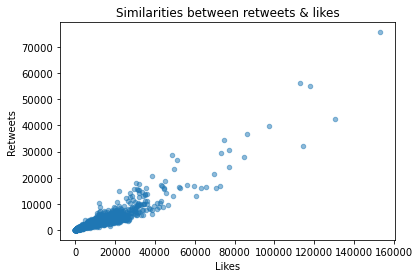

In [64]:
# create scatterplot to show relationship

twitter_archive_clean.plot(kind='scatter',x='favorites',y='retweets', alpha = 0.5)
plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.title('Similarities between retweets & likes')

plt.savefig('scatterplot.png', bbox_inches='tight')

There looks to be a very strong correlation between the amount of retweets & likes

<a id='quest3'></a>
### Question 3 - What did the rating distributions look like?

In [68]:
# create variables for chart
df_integer_ratings_14 = twitter_archive_clean[(twitter_archive_clean.rating_numerator <= 14) & (twitter_archive_clean.rating_numerator.apply(float.is_integer))]
subset_rating_counts = df_integer_ratings_14.groupby(['rating_numerator']).count()['tweet_id']

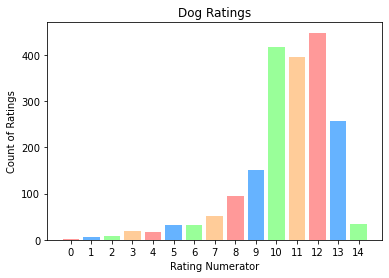

In [69]:
plt.bar(np.arange(15), subset_rating_counts, color=('#ff9999','#66b3ff','#99ff99','#ffcc99'))
plt.xticks(np.arange(15))
plt.xlabel('Rating Numerator')
plt.ylabel('Count of Ratings')
plt.title('Dog Ratings');

plt.savefig('dog_ratings.png', bbox_inches='tight')

### Related Information

In addition to this workbook, the following documentation was created...
- **wrangle_report.html**: documentation of the steps taken for data wrangling in this project
- **act_report.html**: documenation of the basic analysis & insights into the finalized data

This is a list of files that were used in the project..
- **twitter_archive_enhanced.csv**: the original csv file utilized for this project
- **image_predictions.tsv**: images to accompany the twitter_archive downloaded programmatically
- **tweet_json.txt**: tweet info to accompany the twitter_archive constructed via API

This is the final file containing all the combined & cleaned data
- **twitter_archive_master.csv**